**Reminder:**
* Alternative bandwidth selectors
    + Cross-Validation (for example, LSCV or BCV). They often result in wiggly estimates!
    + Plug-in estimators (Sheather-Jones and Improved-Sheather-Jones). Show when they really help (bimodal, for example), but also shown when they are also very wiggly! (leptokurtic, for example).
* Some examples (when they help and when they fail) and final remarks (that SJ / ISJ are recommended).

# 1. Problem statement

Recall the Asymptotic Mean Integrated Squared Error and the bandwidth $h$ that minimizes it: 

$$
\text{AMISE} = \frac{1}{4} h^4 \lVert f'' \rVert^2 + \frac{1}{2N\sqrt{\pi}h}
$$

$$
h_{\text{AMISE}} = \left(\frac{1}{2N\sqrt{\pi} \lVert f'' \rVert^2} \right)^{1 / 5}
$$

The **Gaussian rule of thumb** to estimate $h$ is derived under the assumption that $f$ is a Gaussian density. Despite the criticism at a conceptual level it is indeed a useful rule in many practical situations. On the other hand, its simplicity does not come at a free cost. When the true $f$ differs seriously from a Gaussian distribution, the Gaussian KDE with bandwidth estimated by either Scotts' or Silverman's rule results in a poor alternative.

It can be seen the optimal $h$ depends on $R(f'') = \lVert f'' \rVert^2 = \int{[(f''(x))^2 dx}$, which is a measure of how wiggly $f$ is. AMISE formula tells that higher values of $R(f'')$ result in higher bias. In other words, densities that are more wiggly are more difficult to estimate.

The more $f$ differs from a normal distribution in terms of roughness, the worse the gaussian rule of thumb is. If the density we are trying to estimate has peaks and/or multiple modes, the estimation will oversmooth the true distribution. Particularly, the problem is that we are replacing the true $R(f'')$ with $R(g_{\text{gaussian}}'')$ when actually $R(f'') \gg R(g_{\text{gaussian}}'')$.

Jones, Marron and Sheather (1996) studied the Monte Carlo performance of the normal reference bandwidth based on the 
standard deviation, that is, they considered $h = 1.06sN^{-0.2}$, where $s$ is the sample standard deviation. 
They found that $h$ had a mean that was usually unacceptably large and thus often produced oversmoother density estimates 

### **Remarks**

1. Jones, Marron and Sheather (1996) refers to *A brief survey on bandwidth selection for density estimation* (Jones, Marron and Sheather, 1996)

In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import sys
sys.path.append('../src/')
from my_functions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]

BLUE = "#3498db"
DARK_BLUE = "#2980b9"
NIGHT_BLUE = "#2c3e50"

The following code generates 50 samples of size 3000 from a mixture of Gaussian distributions with variable mean and standard deviation. It can be seen that while the estimator has low variance, it has high bias.  
The density to be estimated is more sinuous than a Gaussian, and consequently, the estimator oversmooths the true $f$. We can appreciate the estimator puts more the density when it is actually very low (i.e. in the left tail) and it fails to detect the two modes on the left part of the plot.

For some applications, the result could still be good enough, as we can see the general pattern of the underlying distribution. For other applications where it is desired to obtain an accurate estimation of the modes, the result is unsastifactory.

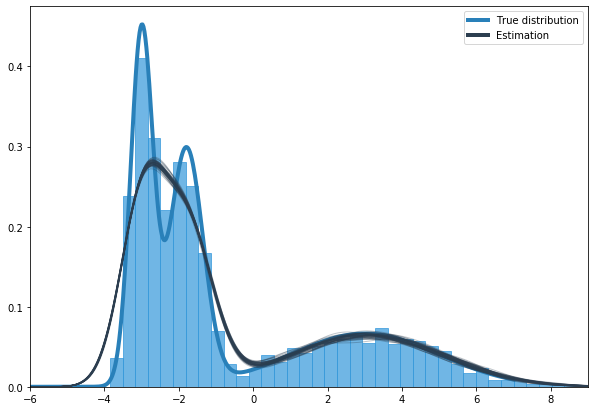

In [3]:
from matplotlib.lines import Line2D

def generate_rvs(n, mean, sd):
    x= np.concatenate((
        list(map(lambda m, s: stats.norm.rvs(m, s, int(n / len(mean))), mean, sd))
    ))
    return x

def get_pdf(x_grid, mean, sd):
    assert len(mean) == len(sd)
    pdf = (1 / len(mean)) * np.sum(list((map(lambda m, s: stats.norm.pdf(x_grid, m, s), mean, sd))), axis=0)
    return pdf

np.random.seed(1234)
x_grid = np.linspace(-6, 7, 500)
mean = [-3, -1.8, 3]
sd = [0.3, 0.45, 2]
n = 3000
reps = 50

colors = [DARK_BLUE, NIGHT_BLUE]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]
labels = ["True distribution", "Estimation"]

pdf_true = get_pdf(x_grid, mean, sd)
plt.plot(x_grid, pdf_true, linewidth=4, color=DARK_BLUE)

for i in range(reps):
    rvs = generate_rvs(n, mean, sd)
    x_kde, y_kde = convolution_kde(rvs)
    plt.plot(x_kde, y_kde, linewidth=1, color=NIGHT_BLUE, alpha=0.3)

plt.hist(rvs, density=True, bins=40, alpha=0.7, Color=BLUE)
plt.xlim(-6, 9)

plt.legend(lines, labels)
plt.show()

## 2. Alternative bandwidth selectors

Many alternative bandwidth selectors for the Gaussian KDE can be found in the literature. An outdated collection of such methods is *A brief survey on bandwidth selection for density estimation* (Jones, Marron and Sheather, 1996). I am not still aware of a similar, but updated, survey.

It is possible to classify bandwidth selection methods in (at least) three groups:

1. Rules of thumb
1. Least Squares Cross-Validation
1. Plug-in Approach

### 1. Rules of thumb

This is the group where Scotts' and Silverman's rules of thumb fall. The basic idea is to replace the unknown part of $h_{AMISE}$, $R(f'')$, by an estimated value based on a parametric family. 

While location is not important when choosing a kernel, the scale parameter is. Because of this and its simplicity is that a Gaussian distribution with mean 0 and standard deviation $\sigma$ is chosen.

### 2. Least Squares Cross-Validation

The idea first appeared in *Empirical Choice of Histograms and Kernel density Estimators* (Rudemo, 1982) and *An Alternative Method of Cross-Validation for the Smoothing of Density Estimate* (Bowman, 1984).

It is possible to measure the closeness of $\hat{f}$ and $f$ for a given sample with the Integrated Squared Error (ISE).

$$
\text{ISE}(\hat{f}(x; h)) = \int{[\hat{f}(x; h) - f(x)]^2}dx
$$

$$
  \begin{split}
    \text{ISE}(\hat{f}(x; h)) & = \int{[\hat{f}(x; h) - f(x)]^2}dx \\
     & = \int{[\hat{f}(x; h)]^2}dx - 2 \int{[\hat{f}(x; h)]^2f(x)}dx + \int{f^2(x)dx}
  \end{split}
$$

It can be noticed the last term of the expansion does not involve $h$. Bowman (1984) proposed choosing the bandwidth as the value of $h$ that minimizes the estiamte of the two other terms

$$
\text{LSCV}(h) = \frac{1}{N} \sum_{i=1}^N{\int[\hat{f}_{-i}(x)]^2 dx} - \frac{2}{N} \sum_{i=1}^N{\hat{f}_{-i}(X_i)}
$$

where $\hat{f}_{-i}(x)$ denotes the kernel estimator constructed from the data without the observation $X_i$. The method is usually referred to as least squares cross-validation, since it is based on the leave-one-out density estimator $\hat{f}_{-i}(x)$.  

In *Large sample optimality of least-squares cross-validation in density estimation* (Hall, 1983) it was shown that

$$
\frac{1}{N} \sum_{i=1}^N{\int[\hat{f}_{-i}(x)]^2 dx} = \int{[\hat{f}(x; h)]^2dx} + O_p\left(\frac{1}{n^2h}\right)
$$

Hence, because of simpler computation, the least squares cross-validation changed its criterion to

$$
\text{LSCV}(h) = \int{[\hat{f}(x; h)]^2dx} - \frac{2}{N} \sum_{i=1}^N{\hat{f}_{-i}(X_i)}
$$

The value of $h$ that minimizes $\text{LSCV}(h)$ is detoned by $h_{\text{LSCV}}$.

**What is the problem with** $h_{\text{LSCV}}$ **?**

* The least squares cross-validation function can have more than one local minimum. In practice, it is recommended to plot the values of $h$ against $\text{LSCV}(h)$ instead of just using a minimization program. Some advice in the literature says to use the largest local minimizer of $\text{LSCV}(h)$ because it gave better empirical results than the global minimizer.
* The rate of convergence of $h_{\text{LSCV}}$ has a rate of convergence of $n^{-1/10}$. Hence, $h_{\text{LSCV}}$ presents very high variability in practice.

The first point makes least squares cross-validation not valid for an automatic usage. The second point is also connected to the fact that the method usually result in very undersmoothed estimations, as opposite to the gaussian rule of thumb.

In [40]:
# -*- coding: utf-8 -*-

# source: https://github.com/JTsolon/least-squares-cross-validation-in-KDE

import numpy as np
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.integrate import quad

'''
This module is designed to find the optimal bandwith under lscv criteria in KDE.
By calling h_cv(sample,a,b), you can get the optimal bandwith that the function return.
parameters:
sample: array-like
a: lower bound of the population, not necessarily accurate
b: upper bound of the population, not necessarily accurate
return: bandwidth, float
'''

#compute the asymptotic squared error, return the cv,squared error minus the integral of raw pdf
def squared_error(h,sample,a,b):
    '''h is a 1-D array
       sample:array_like
       a:lower bound of the support of rv
       b:upper bound of the support of rv'''
       
    h=h[0]
    dens=sm.nonparametric.KDEUnivariate(sample)
    dens.fit(kernel='gau',bw=h)
    f_n_square=lambda x:dens.evaluate(x)[0]**2 #whole sample estimated pdf
    
    #compute the mean of cross prediction value
    def f_sub_sample_mean():
        summation=0
        for i in range(len(sample)):
            subsample=sample.copy()
            del subsample[i]
            dens1=sm.nonparametric.KDEUnivariate(subsample)
            dens1.fit(kernel='gau',bw=h)
            predict_value=dens.evaluate(sample[i])[0]
            summation+=predict_value
        return summation/len(sample)
    
    cv=abs(2*quad(f_n_square,a,b)[0]-2*f_sub_sample_mean()) 
    return cv
    
#find the optimal bandwith h minimizing cv and return it
def h_cv(sample,a,b):
    '''sample:array_like
       a:lower bound of the support of rv
       b:upper bound of the support of rv'''
    h0=[np.array(sample).std()*(len(sample)**(-0.2))] #the initial value of h
    
    # following, h here is constraint to be larger than 10**(-8), otherwise it could be zero when do optimization, 
    # which will raise a 'ZeroDivisionError' exception in method 'evaluate(points)'
    cons=({'type':'ineq','fun':lambda x:x[0]-10**(-8)})
    res=minimize(squared_error,h0,args=(sample,a,b),constraints=cons)
    h=res.x #the optimal h
    #value=res.fun
    
    return h[0]

C:\Users\Tomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


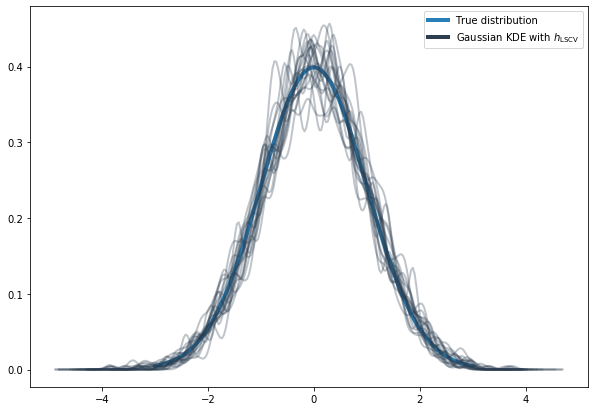

In [39]:
np.random.seed(1234)
colors = [DARK_BLUE, NIGHT_BLUE]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]
labels = ["True distribution", r"Gaussian KDE with $h_{\mathrm{LSCV}}$"]

x_grid = np.linspace(-3, 3, 500)
plt.plot(x_grid, stats.norm.pdf(x_grid), linewidth=4, color=DARK_BLUE)

for i in range(20):
    rvs = np.random.normal(size=1000).tolist()
    h_lscv = h_cv(rvs, -3, 3)
    x_kde, y_kde = convolution_kde(rvs, h=h_lscv)
    plt.plot(x_kde, y_kde, linewidth=2, color=NIGHT_BLUE, alpha=0.3)

plt.legend(lines, labels)
plt.show()

Not only biased and variable, but also very slow.